In [1]:
from keras import backend as K, models
from keras.models import *
from keras.layers import *
from keras.layers.normalization import BatchNormalization
from keras.applications import MobileNetV2
from keras.regularizers import l2
from keras.activations import relu
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
from os.path import join as join_
import numpy as np
from PIL import Image
import cv2

Using TensorFlow backend.


In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12124302983944637549
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17606941499958503686
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17567937925089988474
physical_device_desc: "device: XLA_GPU device"
]
Num GPUs Available:  0


In [3]:
# Setting up the dataset

SET_DIR = '../AMI/'
NUM_CLASSES = len(os.listdir('../AMI/'))

# The shape which MobilenetV2 accepts as input and thus each image is resized to
image_shape = (224, 224, 3)

# NUM_EXAMPLES is the number of (A,P,N) triplets chosen for the same class (N belongs to a different class of course)
NUM_EXAMPLES = 15

# Triplets list will contain anchor(A), positive(P) and negative(N) triplets.
triplets = []
A = P = N = []

# creating anchor, positive, negative triplets
for _ in range(NUM_EXAMPLES):
    for direc in os.listdir(SET_DIR):
        dir_path = SET_DIR + direc
        dir_contents = os.listdir(dir_path)
        length = len(dir_contents)
        
        anchor = np.asarray(Image.open(join_(dir_path, dir_contents[np.random.randint(0, length)])))/255
        anchor = cv2.resize(anchor, (180, 200)) 
        anchor = np.array([np.pad(a, ((22,22), (12,12)), 'constant') for a in anchor.T]).T
        
        
        positive = np.asarray(Image.open(join_(dir_path, dir_contents[np.random.randint(0, length)])))/255
        positive = cv2.resize(positive, (180, 200)) 
        positive = np.array([np.pad(a, ((22,22), (12,12)), 'constant') for a in positive.T]).T
        
        neg_dir = os.listdir(SET_DIR)[np.random.randint(NUM_CLASSES)]
        while neg_dir == direc: 
            neg_dir = os.listdir(SET_DIR)[np.random.randint(NUM_CLASSES)]
            
        length_negative = len(os.listdir(SET_DIR + neg_dir))
        negative = np.asarray(Image.open(
                       join_(SET_DIR + neg_dir, 
                        os.listdir(SET_DIR + neg_dir)[np.random.randint(0, length_negative)])))/255
        negative = cv2.resize(negative, (180, 200)) 
        negative = np.array([np.pad(a, ((22,22), (12,12)), 'constant') for a in negative.T]).T
        
        # append triplet
        triplets.append([anchor, positive, negative])
        A.append(anchor)
        P.append(positive)
        N.append(negative)

In [4]:
def triplet_function(vects, alpha=0.4):
    x, y, z = vects
    sum_square_xy = K.sum(K.square(x - y), axis=1, keepdims=True)
    sum_square_xz = K.sum(K.square(x - z), axis=1, keepdims=True)
    return K.sum(K.maximum(sum_square_xy - sum_square_xz + alpha, 0), axis=0)


In [5]:
def VGG():
    image_input = Input(shape=(224, 224, 3))
    model = MobileNetV2(input_tensor=image_input, weights='imagenet',include_top=True)
    model.layers[-1].activation = relu
    x_out = Dense(32)(model.layers[-1].output)
    
    new_model = Model(inputs=image_input, outputs=x_out)
    return new_model

In [7]:
def get_model():
    anchor = Input(shape=image_shape, name='anchor')
    positive = Input(shape=image_shape, name='positive')
    negative = Input(shape=image_shape, name='negative')
    
    # Passing each image through the VGG model
    anchor_encoding = VGG()(anchor)
    positive_encoding = VGG()(positive)
    negative_encoding = VGG()(negative)

    # Incorporating the triplet loss in the SimVecLayer
    SimVecLayer = Lambda(triplet_function, output_shape=(1,))
    
    sim_APN = SimVecLayer([anchor_encoding, positive_encoding, negative_encoding])
    
    return Model(inputs=[anchor, positive, negative], outputs=sim_APN)

In [8]:
model = get_model()

# Compile the model with a loss and optimizer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae']) 
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
positive (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
negative (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32)           3571016     anchor[0][0]                     
____________________________________________________________________________________________

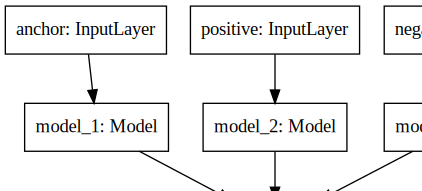

In [17]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [9]:
# Train the model (done over the intel cloud) 
model.fit(x = [A, P, N], y = np.zeros((len(A),1)),
                  epochs=10, verbose=1,
                  batch_size=32, validation_split=0.3,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

In [9]:
model.save('model.h5')

NameError: name 'model' is not defined